### Wymagania:
## NA KOŃCU - RAPORTY
1. Należy przygotować sobie bazę danych do klasyfikacji zdjęć (binarną lub
wieloklasową) ✅
2. Wytrenować model na sieci ResNet50 od zera (bez transfer learningu) na CPU
- uzyskane wyniki (czas treningu oraz dokładność) będą stanowić base line
dla kolejnych wyników. ✅
3. W celu optymalizacji szybkości treningu zastosować:
- a. akcelerator GPU - przygotować raport porównawczy z czasem trenowania
bez i z GPU,
- b. transfer learning - przygotować raport porównawczy z transfer
learningiem i bez, interesuje nas tutaj dojście do pewnego poziomu
dokładności np. 80%. ✅
4. W celu optymalizacji dokładności zastosować:
- a. normalizację - przygotować raport porównawczy z normalizacją danych i
bez.
- b. augumentację danych - przygotować raport porównawczy z
augumentacją i bez + informacją jakie przekształcenia zostały
przeprowadzone. ✅ DODAC MALY MODEL BEZ AUGMENTACJI !!
- c. dropout - przygotować raport porównawczy z zastosowaniem dropoutu i
bez.
- d. dokładanie danych - przygotować raport porównawczy z dołożeniem
nowej partii danych i bez. (zrobic oversampling?)
- e. różne rozmiary wejściowe (np. 96x96, 160x160, 224x224) - przygotować
raport porównawczy dla każdego rozmiaru.
- f. różny rozmiar Batch size (np. 32, 64, 128) - przygotować raport
porównawczy dla każdego rozmiaru.
- g. różne struktury sieci (np. VGG16, ResNet101, InceptionV3, MobileNet) -
przygotować raport porównawczy dla każdej sieci (min. 4).

## 0. Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import zipfile
import time
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

## 1. Loading dataset + quick exploration

In [2]:
! pip install -q kaggle

In [ ]:
# kaggle token
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
! kaggle datasets download -d uraninjo/augmented-alzheimer-mri-dataset
with zipfile.ZipFile("augmented-alzheimer-mri-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("alzheimer_dataset")

Dataset URL: https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset
License(s): GNU Lesser General Public License 3.0
augmented-alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
image_count = len(list(glob.glob('alzheimer_dataset/OriginalDataset/**/*.jpg')))
print(f'{image_count} examples of MRI brain photos in augmented dataset')

6400 examples of MRI brain photos in augmented dataset


In [7]:
base_dir = 'alzheimer_dataset/OriginalDataset'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


In [8]:
alzheimer_df.shape

(6400, 2)

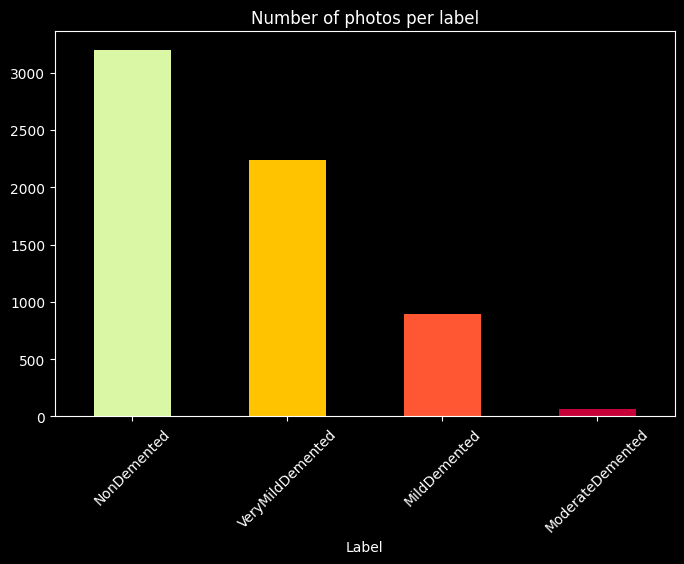

In [ ]:
import matplotlib.pyplot as plt
counts = alzheimer_df['labels'].value_counts()

colors = ['#DAF7A6', '#FFC300', '#FF5733', '#C70039']
counts.plot(kind='bar', color=colors, figsize=(8,5))

plt.title("Number of photos per label")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.style.use('dark_background')
plt.show()

Example of moderate demented brain VS non demented brain from dataset


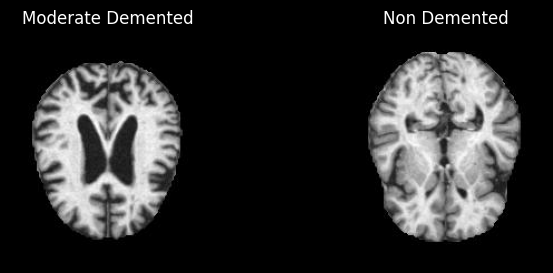

L


In [ ]:
moderate_demented_example = list(glob.glob('alzheimer_dataset/OriginalDataset/ModerateDemented/*'))
non_demented_example = list(glob.glob('alzheimer_dataset/OriginalDataset/NonDemented/*'))
print('Example of moderate demented brain VS non demented brain from dataset')
img_demented = PIL.Image.open(str(moderate_demented_example[5])).convert('L')
img_non_demented = PIL.Image.open(str(non_demented_example[5])).convert('L')
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].imshow(img_demented, cmap='gray')
axs[0].set_title("Moderate Demented")
axs[0].axis('off')

axs[1].imshow(img_non_demented, cmap='gray')
axs[1].set_title("Non Demented")
axs[1].axis('off')

plt.style.use('dark_background')
plt.show()
print(img_demented.mode)

## 4b. Augmentation - classes in this dataset are way too imbalanced, so I am doing this step here to make further training meaningful

In [9]:
img_height = 64
img_width = 64
target_per_class = 2000

original_dataset_dir = 'alzheimer_dataset/OriginalDataset'
augmented_dataset_dir = 'augmented_dataset'
os.makedirs(augmented_dataset_dir, exist_ok=True)

# for MildDemented and ModerateDemented (they have too little images)
classes_to_augment = {
    'ModerateDemented': 'alzheimer_dataset/OriginalDataset/ModerateDemented',
    'MildDemented': 'alzheimer_dataset/OriginalDataset/MildDemented'
}

In [10]:
augmented_base_dir = 'temp'
os.makedirs(augmented_base_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rotation_range=15, # randomly rotate by 15 degress
    width_shift_range=0.1, # shift horizontally
    height_shift_range=0.1, # shift vertically
    zoom_range=0.2, # zoom 20%
    horizontal_flip=True, # flip horizontally
    fill_mode='nearest' # fills empty pixels (that occur after flipping) on img with nearest pixels
)

for class_name, input_dir in classes_to_augment.items():
    output_dir = os.path.join(augmented_base_dir, class_name)
    os.makedirs(output_dir, exist_ok=True)

    # copy original images
    originals = [f for f in os.listdir(input_dir) if f.lower().endswith('.jpg')]
    for fname in originals:
        src = os.path.join(input_dir, fname)
        dst = os.path.join(output_dir, fname)
        if not os.path.exists(dst):
            img = load_img(src)
            img.save(dst)

    generated = 0
    i = 0
    total_samples_needed = max(0, target_per_class - len(originals))

    while generated < total_samples_needed:
        img_path = os.path.join(input_dir, originals[i % len(originals)])
        img = load_img(img_path, target_size=(img_height, img_width))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0) # batch

        for batch in augmentor.flow(x, batch_size=1):
            aug_path = os.path.join(output_dir, f"aug_{generated}.jpg")
            save_img(aug_path, batch[0])
            generated += 1
            break  # after image has been augmented

In [11]:
# results of augmentation (should be 2000 samples each class)
base_dir = 'temp'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
ModerateDemented    2000
MildDemented        2000
Name: count, dtype: int64


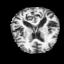

In [12]:
mild_d = list(glob.glob('temp/MildDemented/*'))
PIL.Image.open(str(mild_d[1600]))

In [13]:
# merge datasets
import shutil
import os

original_dirs = {
    'NonDemented': 'alzheimer_dataset/OriginalDataset/NonDemented',
    'VeryMildDemented': 'alzheimer_dataset/OriginalDataset/VeryMildDemented',
}
augmented_dirs = {
    'MildDemented': 'temp/MildDemented',
    'ModerateDemented': 'temp/ModerateDemented',
}

final_base = 'augmented_ds'

def copy_images(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        if fname.lower().endswith(('.jpg')):
            src = os.path.join(src_dir, fname)
            dst = os.path.join(dst_dir, fname)
            shutil.copy(src, dst)

for label, path in original_dirs.items():
    copy_images(path, os.path.join(final_base, label))

for label, path in augmented_dirs.items():
    copy_images(path, os.path.join(final_base, label))

In [14]:
base_dir = 'augmented_ds'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

print('Labels and number of photos')
print('-'*10)
print(alzheimer_df["labels"].value_counts())

Labels and number of photos
----------
labels
NonDemented         3200
VeryMildDemented    2240
ModerateDemented    2000
MildDemented        2000
Name: count, dtype: int64


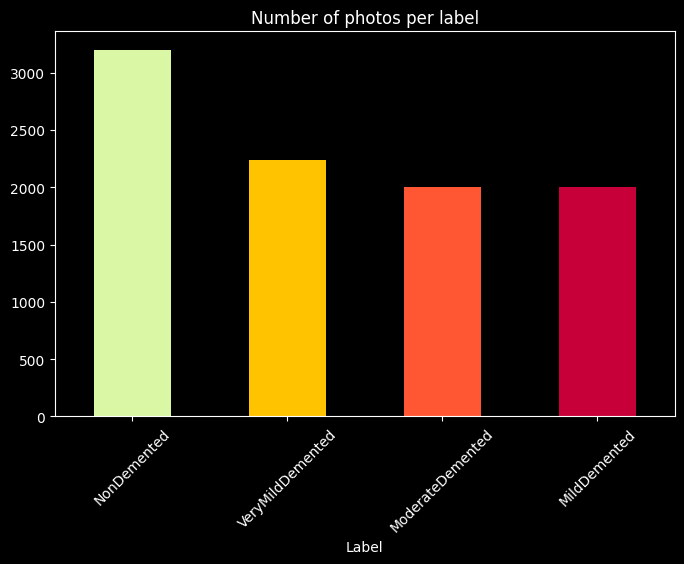

In [ ]:
counts = alzheimer_df['labels'].value_counts()

colors = ['#DAF7A6', '#FFC300', '#FF5733', '#C70039']
counts.plot(kind='bar', color=colors, figsize=(8,5))

plt.title("Number of photos per label")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.style.use('dark_background')
plt.show()

## 2. ResNet50 without transfer learning on CPU

In [17]:
batch_size = 32
class_count = 4

In [ ]:
small_df = alzheimer_df.sample(n=5000, random_state=42) # training on 5000 samples because im not waiting 3 days
train_val_set, test_set = train_test_split(
    small_df,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

print(f"Number of training samples: {len(train_set)}")
print(f"Number of validation samples: {len(val_set)}")
print(f"Number of testing samples: {len(test_set)}")

Number of training samples: 3200
Number of validation samples: 800
Number of testing samples: 1000


In [ ]:
img_gen = ImageDataGenerator() # makes it possible to load images in batches rather than all at once
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width), # changing size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


In [ ]:
test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1000 validated image filenames belonging to 4 classes.


In [ ]:
input_shape = (img_height, img_width, 3) # image input size
resnet50_base_model = ResNet50(include_top=False,
                         weights=None, # no transfer learning
                         classes=class_count,
                         input_shape=input_shape)

x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x) # what the siet
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.5038 - loss: 1.5179 - val_accuracy: 0.2087 - val_loss: 3.5019
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 488s 5s/step - accuracy: 0.7127 - loss: 0.7174 - val_accuracy: 0.4338 - val_loss: 1.8393
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 484s 5s/step - accuracy: 0.7490 - loss: 0.5804 - val_accuracy: 0.7025 - val_loss: 0.8339
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.8286 - loss: 0.4395 - val_accuracy: 0.7088 - val_loss: 0.6123
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 517s 5s/step - accuracy: 0.8588 - loss: 0.3775 - val_accuracy: 0.6250 - val_loss: 1.4226
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 509s 5s/step - accuracy: 0.8870 - loss: 0.2959 - val_accuracy: 0.7450 - val_loss: 0.9640
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 506s 5s/step - accuracy: 0.8697 - loss: 0.3505 - val_accuracy: 0.7387 - val_loss: 0.9940
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 511s 5s/step - accuracy: 0.8909 - loss: 0.2934 - val_accuracy: 0.765

In [ ]:
resnet50_base_training_time = training_end_time - training_start_time
test_loss, resnet50_base_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_base_accuracy:.4f}')
print(f'Training took {resnet50_base_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.6973 - loss: 1.0006
--------------------------------------------------
Test accuracy: 0.6960
Training took 84.25 minutes


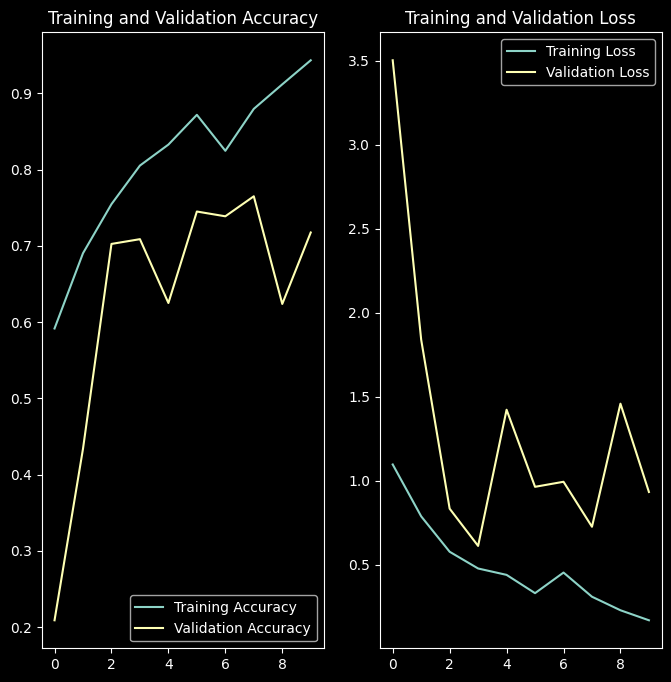

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 3a. ResNet50 without transfer learning on GPU

In [ ]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 94ms/step - accuracy: 0.4861 - loss: 1.5733 - val_accuracy: 0.3212 - val_loss: 1.9947
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.7257 - loss: 0.6747 - val_accuracy: 0.3075 - val_loss: 2.5390
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7765 - loss: 0.5489 - val_accuracy: 0.3775 - val_loss: 1.7741
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7587 - loss: 0.6257 - val_accuracy: 0.6300 - val_loss: 1.5592
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7806 - loss: 0.5857 - val_accuracy: 0.6812 - val_loss: 1.2331
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8613 - loss: 0.3801 - val_accuracy: 0.6938 - val_loss: 1.2065
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8911 - loss: 0.2758 - val_accuracy: 0.7088 - val_loss: 0.9357
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9146 - loss: 0.2503 - val_accuracy: 0

In [ ]:
resnet50_gpu_training_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_gpu_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7790 - loss: 0.6854
--------------------------------------------------
Test accuracy: 0.7810
Training took 2.16 minutes


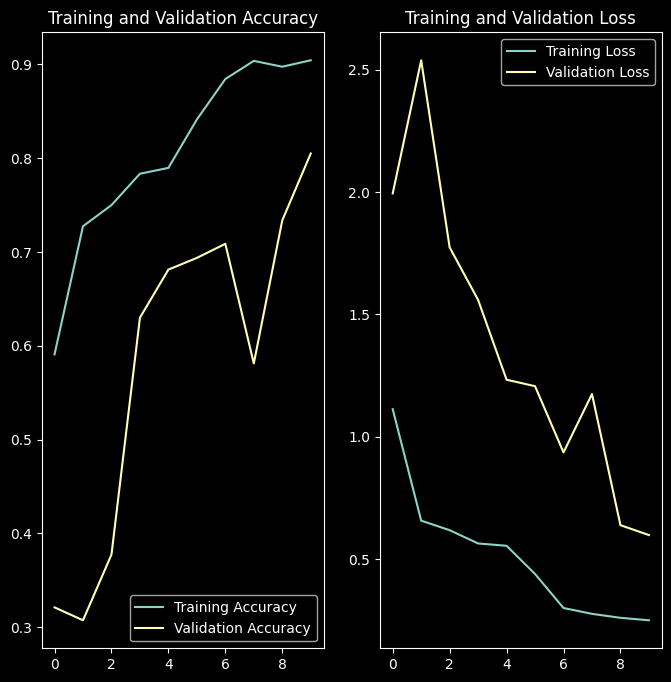

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 3b. ResNet50 with transfer learning on GPU

In [ ]:
input_shape = (img_height, img_width, 3)
resnet50_transferlearning_model = ResNet50(include_top=False,
                         weights='imagenet', # transfer learning
                         classes=class_count,
                         input_shape=input_shape)
resnet50_transferlearning_model.trainable = False

x = resnet50_transferlearning_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_transferlearning_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.5570 - loss: 1.0464 - val_accuracy: 0.6862 - val_loss: 0.7003
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6873 - loss: 0.6980 - val_accuracy: 0.6862 - val_loss: 0.6677
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7136 - loss: 0.6397 - val_accuracy: 0.6988 - val_loss: 0.6363
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7200 - loss: 0.6053 - val_accuracy: 0.7387 - val_loss: 0.6111
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7639 - loss: 0.5375 - val_accuracy: 0.7387 - val_loss: 0.5742
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7428 - loss: 0.5733 - val_accuracy: 0.7312 - val_loss: 0.5989
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7730 - loss: 0.5105 - val_accuracy: 0.7525 - val_loss: 0.5554
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7834 - loss: 0.4907 - val_acc

In [ ]:
resnet50_tl_training_time = training_end_time - training_start_time
test_loss, resnet50_tl_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_tl_accuracy:.4f}')
print(f'Training took {resnet50_tl_training_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7460 - loss: 0.5678
--------------------------------------------------
Test accuracy: 0.7430
Training took 0.69 minutes


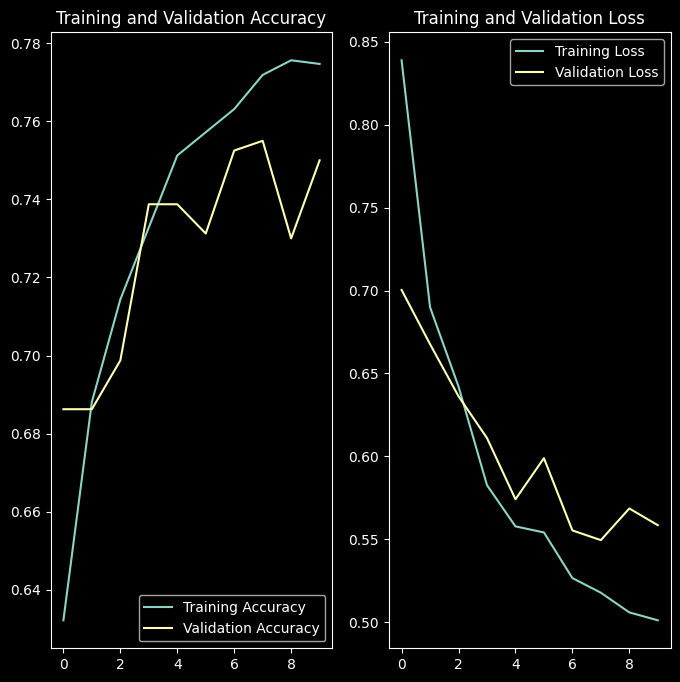

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## Same model, but without augmentation

In [ ]:
base_dir = 'alzheimer_dataset/OriginalDataset'

filepaths = []
labels = []

for label in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, label)
    if os.path.isdir(folder_path):
        for fname in os.listdir(folder_path):
            filepaths.append(os.path.join(folder_path, fname))
            labels.append(label)
alzheimer_df_0 = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

small_df_0 = alzheimer_df_0.sample(n=5000, random_state=42)
train_val_set_0, test_set_0 = train_test_split(
    small_df_0,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set_0, val_set_0 = train_test_split(
    train_val_set_0,
    test_size=0.2,
    stratify=train_val_set_0['labels'],
    random_state=42)

img_gen = ImageDataGenerator() # makes it possible to load images in batches rather than all at once
train_generator_0 = img_gen.flow_from_dataframe(
    dataframe=train_set_0,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width), # changing size for faster training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator_0 = img_gen.flow_from_dataframe(
    dataframe=val_set_0,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator_0 = img_gen.flow_from_dataframe(
    dataframe=test_set_0,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
not_augmented = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
not_augmented.trainable = False

x = not_augmented.output
x = GlobalAveragePooling2D()(x)
outputs_0 = Dense(class_count, activation='softmax')(x)
model_not_augmented = Model(inputs=not_augmented.input, outputs=outputs_0)

model_not_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.
Found 1000 validated image filenames belonging to 4 classes.


In [ ]:
training_start_time = time.time()
history_0 = model_not_augmented.fit(train_generator_0,
                    validation_data = val_generator_0,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.4717 - loss: 1.2677 - val_accuracy: 0.5612 - val_loss: 1.0105
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5822 - loss: 0.9248 - val_accuracy: 0.5700 - val_loss: 0.9006
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5978 - loss: 0.8664 - val_accuracy: 0.5838 - val_loss: 0.8790
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6240 - loss: 0.8274 - val_accuracy: 0.6050 - val_loss: 0.8361
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6697 - loss: 0.7698 - val_accuracy: 0.6237 - val_loss: 0.8428
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6526 - loss: 0.7667 - val_accuracy: 0.6112 - val_loss: 0.8248
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6727 - loss: 0.7346 - val_accuracy: 0.5838 - val_loss: 0.9078
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6511 - loss: 0.7513 - val_accuracy: 0.63

In [ ]:
not_augmented_time = training_end_time - training_start_time
test_loss, na_accuracy = model_not_augmented.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {na_accuracy:.4f}')
print(f'Training took {not_augmented_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5027 - loss: 1.5891
--------------------------------------------------
Test accuracy: 0.5140
Training took 0.73 minutes


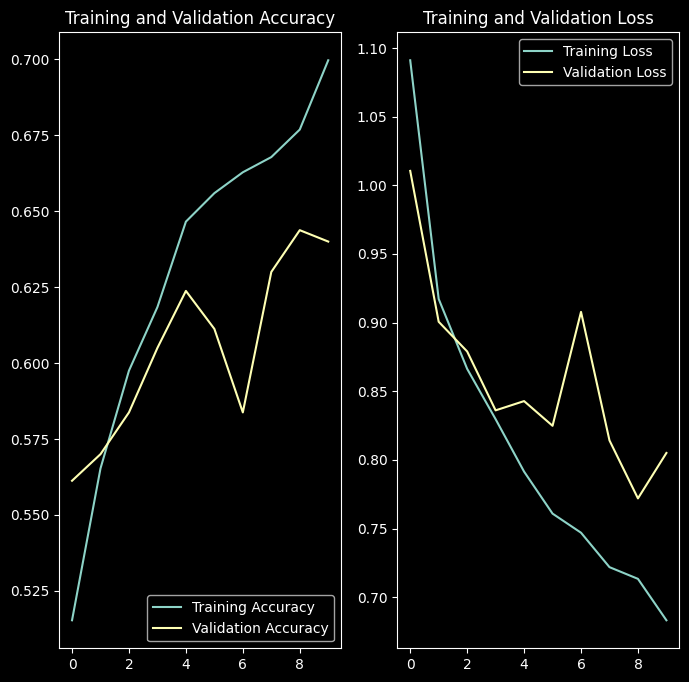

In [ ]:
acc = history_0.history['accuracy']
val_acc = history_0.history['val_accuracy']

loss = history_0.history['loss']
val_loss = history_0.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4a. Normalization

In [15]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [22]:
img_height = 64
img_width = 64
class_count = 4

In [21]:
small_df = alzheimer_df.sample(n=5000, random_state=42)
train_val_set, test_set = train_test_split(
    small_df,
    test_size=0.2,
    stratify=small_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3200 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.
Found 1000 validated image filenames belonging to 4 classes.


In [25]:
input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.5439 - loss: 1.2167 - val_accuracy: 0.6725 - val_loss: 0.7108
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6904 - loss: 0.6830 - val_accuracy: 0.7425 - val_loss: 0.6204
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7168 - loss: 0.6412 - val_accuracy: 0.6975 - val_loss: 0.6563
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7216 - loss: 0.6120 - val_accuracy: 0.7200 - val_loss: 0.6252
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7284 - loss: 0.5904 - val_accuracy: 0.7362 - val_loss: 0.5970
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7626 - loss: 0.5415 - val_accuracy: 0.7138 - val_loss: 0.6388
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7710 - loss: 0.5087 - val_accuracy: 0.7275 - val_loss: 0.5926
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7707 - loss: 0.5140 - val_accuracy: 0.72

In [28]:
resnet50_normalized_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_normalized_time:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7578 - loss: 0.5497
--------------------------------------------------
Test accuracy: 44.7110
Training took 0.75 minutes


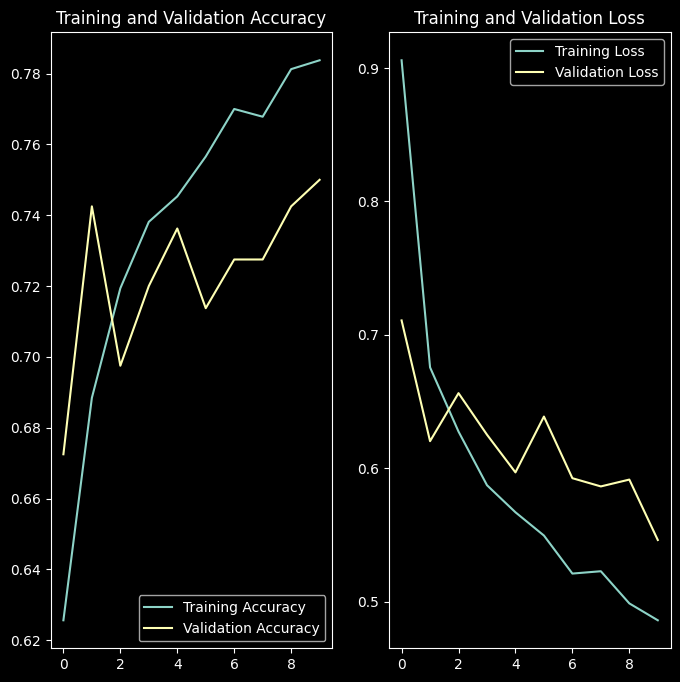

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4c. Dropout

In [31]:
from tensorflow.keras.layers import Dropout

In [44]:
input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x) # half of neurons in a layer will be turned off randomly

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.4741 - loss: 1.9158 - val_accuracy: 0.7000 - val_loss: 0.7224
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6242 - loss: 1.0779 - val_accuracy: 0.7287 - val_loss: 0.6575
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6650 - loss: 0.8178 - val_accuracy: 0.7188 - val_loss: 0.6476
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6981 - loss: 0.7366 - val_accuracy: 0.6862 - val_loss: 0.6592
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7022 - loss: 0.7240 - val_accuracy: 0.7163 - val_loss: 0.6175
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7034 - loss: 0.6894 - val_accuracy: 0.7237 - val_loss: 0.6469
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7044 - loss: 0.6691 - val_accuracy: 0.7350 - val_loss: 0.6046
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7355 - loss: 0.6299 - val_acc

In [46]:
resnet50_normalized_time = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_normalized_time:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7139 - loss: 0.6174
--------------------------------------------------
Test accuracy: 41.3057
Training took 0.69 minutes


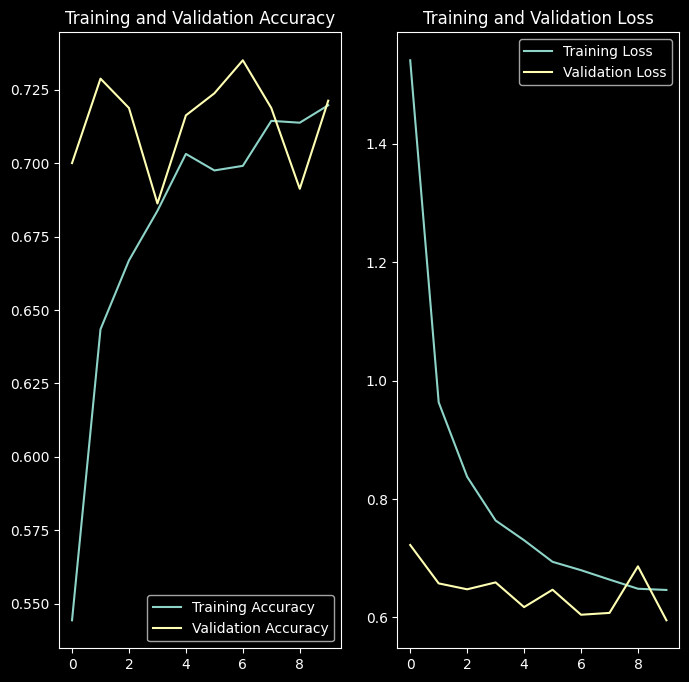

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4d. Adding data (using whole dataset instead of samples :) )

In [60]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [61]:
input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 68ms/step - accuracy: 0.4987 - loss: 1.7829 - val_accuracy: 0.7148 - val_loss: 0.6361
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6648 - loss: 0.8245 - val_accuracy: 0.7214 - val_loss: 0.6018
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6845 - loss: 0.7275 - val_accuracy: 0.6909 - val_loss: 0.7582
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6977 - loss: 0.6962 - val_accuracy: 0.7247 - val_loss: 0.5856
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7199 - loss: 0.6553 - val_accuracy: 0.7373 - val_loss: 0.5642
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7093 - loss: 0.6476 - val_accuracy: 0.7068 - val_loss: 0.6593
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6972 - loss: 0.6881 - val_accuracy: 0.7432 - val_loss: 0.5611
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7158 - loss: 0.6446 - val_accuracy: 0.75

In [63]:
resnet50_whole= training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_whole:.4f}')
print(f'Training took {resnet50_whole / 60:.2f} minutes')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7316 - loss: 0.5999
--------------------------------------------------
Test accuracy: 65.9601
Training took 1.10 minutes


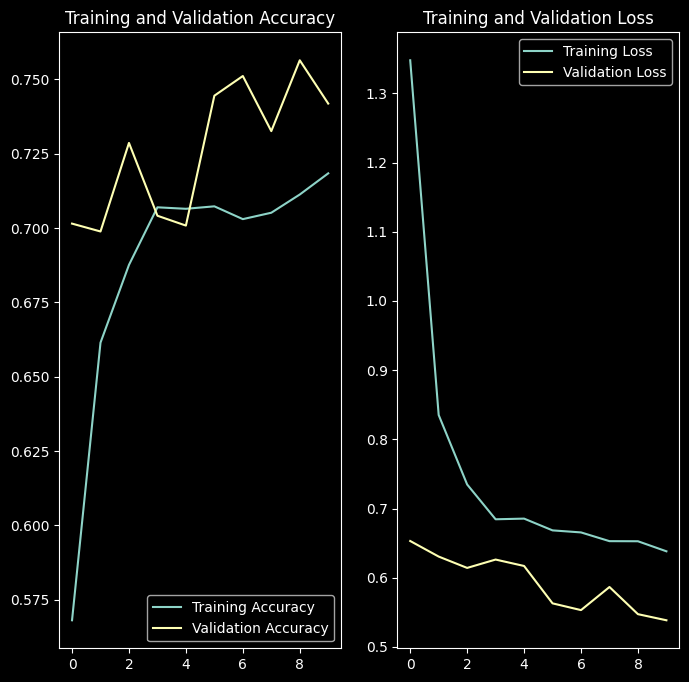

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

## 4e. Different input sizes

### 96x96

In [64]:
img_height = 96
img_width = 96

In [65]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [66]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4992 - loss: 1.7670 - val_accuracy: 0.6956 - val_loss: 0.7201
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6611 - loss: 0.8266 - val_accuracy: 0.7055 - val_loss: 0.6315
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6856 - loss: 0.7338 - val_accuracy: 0.7280 - val_loss: 0.5783
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6949 - loss: 0.6811 - val_accuracy: 0.7293 - val_loss: 0.5591
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7038 - loss: 0.6619 - val_accuracy: 0.7346 - val_loss: 0.5784
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7025 - loss: 0.6811 - val_accuracy: 0.7452 - val_loss: 0.5518
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7126 - loss: 0.6356 - val_accuracy: 0.7432 - val_loss: 0.5509
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7246 - loss: 0.6128 - val_accuracy: 0.75

In [67]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6979 - loss: 0.6481
--------------------------------------------------
Test accuracy: 0.7140
Training took 0.69 minutes


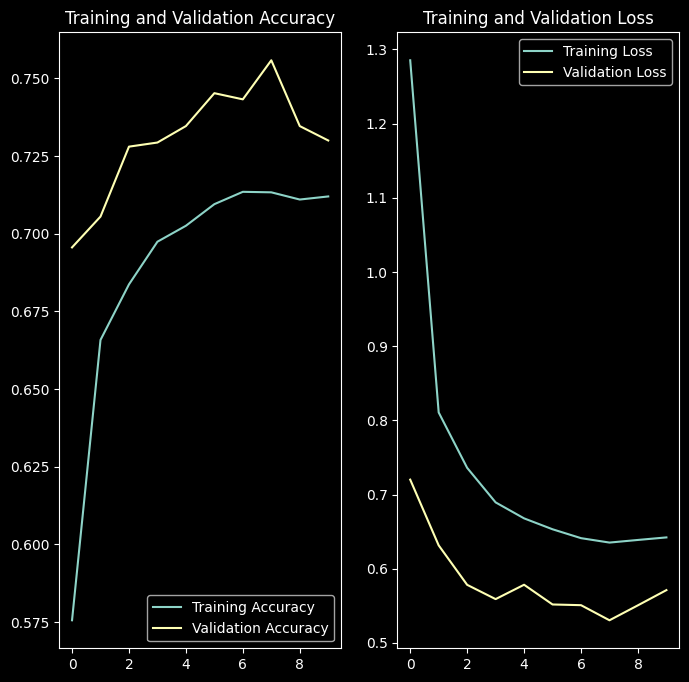

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

### 160x160

In [69]:
img_height = 160
img_width = 160

In [70]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [78]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7568 - loss: 0.5404 - val_accuracy: 0.7591 - val_loss: 0.5170
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 66ms/step - accuracy: 0.7474 - loss: 0.5633 - val_accuracy: 0.7869 - val_loss: 0.4838
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.7578 - loss: 0.5354 - val_accuracy: 0.7472 - val_loss: 0.5463
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.7625 - loss: 0.5184 - val_accuracy: 0.7531 - val_loss: 0.5200
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7381 - loss: 0.5584 - val_accuracy: 0.7842 - val_loss: 0.4773
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7545 - loss: 0.5641 - val_accuracy: 0.7684 - val_loss: 0.4928
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.7578 - loss: 0.5419 - val_accuracy: 0.7915 - val_loss: 0.4689
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.7506 - loss: 0.5466 - 

In [79]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7359 - loss: 0.5451
--------------------------------------------------
Test accuracy: 0.7479
Training took 0.69 minutes


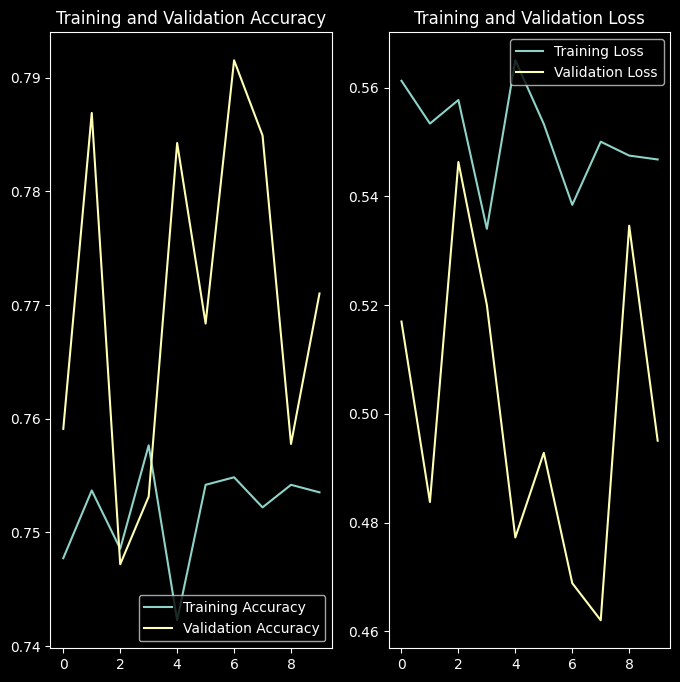

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()

In [ ]:
# what the fak happened here

### 224x224

In [83]:
img_height = 224
img_width = 224

In [82]:
train_val_set, test_set = train_test_split(
    alzheimer_df,
    test_size=0.2,
    stratify=alzheimer_df['labels'],
    random_state=42)

train_set, val_set = train_test_split(
    train_val_set,
    test_size=0.2,
    stratify=train_val_set['labels'],
    random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

img_gen = ImageDataGenerator()
train_generator = img_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = img_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = img_gen.flow_from_dataframe(
    dataframe=test_set,
    x_col='filepaths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

input_shape = (img_height, img_width, 3)
resnet50_base_model = ResNet50(include_top=False,
                         weights='imagenet',
                         classes=class_count,
                         input_shape=input_shape)
resnet50_base_model.trainable = False
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)

outputs = Dense(class_count, activation='softmax')(x)
model = Model(inputs=resnet50_base_model.input, outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 6041 validated image filenames belonging to 4 classes.
Found 1511 validated image filenames belonging to 4 classes.
Found 1888 validated image filenames belonging to 4 classes.


In [84]:
training_start_time = time.time()
history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=10)
training_end_time = time.time()

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 48s 178ms/step - accuracy: 0.5486 - loss: 1.1759 - val_accuracy: 0.7227 - val_loss: 0.6167
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6892 - loss: 0.6945 - val_accuracy: 0.7187 - val_loss: 0.6051
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.6959 - loss: 0.6489 - val_accuracy: 0.7227 - val_loss: 0.5734
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7192 - loss: 0.6166 - val_accuracy: 0.7426 - val_loss: 0.5417
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.7141 - loss: 0.6169 - val_accuracy: 0.7571 - val_loss: 0.5368
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7312 - loss: 0.5785 - val_accuracy: 0.7406 - val_loss: 0.5378
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.7349 - loss: 0.5689 - val_accuracy: 0.7406 - val_loss: 0.5378
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.7430 - loss: 0.5685 - val

In [85]:
resnet50 = training_end_time - training_start_time
test_loss, resnet50_gpu_accuracy = model.evaluate(test_generator)
print('-'*50)
print(f'Test accuracy: {resnet50_gpu_accuracy:.4f}')
print(f'Training took {resnet50_normalized_time / 60:.2f} minutes')

59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.7658 - loss: 0.5298
--------------------------------------------------
Test accuracy: 0.7622
Training took 0.69 minutes


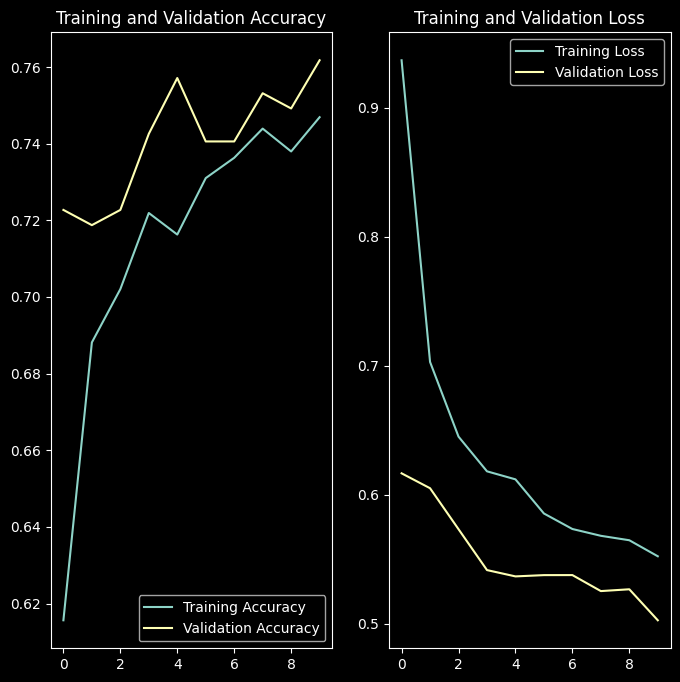

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.style.use('dark_background')
plt.show()